# Encoder Detach Ratio and Consistency Loss




This notebook analyzes how detaching the encoder halfway through training (ratio 0.5)

affects one-step consistency losses for two tasks:



- Quadruped Walk

- Acrobot Swing-Up



For each task, we compare runs where the encoder is never detached against runs where

`detach_encoder_ratio == 0.5`, focusing on training and validation one-step consistency

metrics over environment steps.

In [1]:
from pathlib import Path
import sys

NOTEBOOK_DIR = Path().resolve()
REPO_ROOT = NOTEBOOK_DIR.parent.parent
if not (REPO_ROOT / "analysis" / "tools").exists():
    raise RuntimeError("Unable to locate analysis/tools package from notebook directory")
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from analysis.tools import consistency_analysis, plotting

sns.set_context("talk")
sns.set_style("whitegrid")

# TU Delft-inspired contrasting color palette (blue, cyan, orange, green)
TUDELFT_COLORS = {
    "detach_0.0": "#00A6D6",   # Delft blue
    "detach_0.5": "#FF8F00",   # Bright orange
}
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=[TUDELFT_COLORS["detach_0.0"], TUDELFT_COLORS["detach_0.5"]])

In [3]:
NOTEBOOK_STEM = "encoder_detach_consistency"
SWEEP_ROOT = Path("../../sweep_list").resolve()

# Sweep configuration for detach-encoder experiments
ENTITY = "thomasevers9"
PROJECT = "tdmpc2-tdmpc2"
SWEEP_IDS = {
    "acrobot-swingup": "0mhaabs9",  # 8finalsweep/stop_encoder (DMControl task name)
    "quadruped-walk": "0mhaabs9",  # same sweep includes both tasks
}

# Consistency-related history keys to request from W&B.
# Metric names follow the pattern:
#   <split>/consistency_loss/step<k>
# for k in {0, 1}. Note validation splits use
 # 'validation_recent' and 'validation_all'.
CONSISTENCY_HISTORY_KEYS = [
    "train/consistency_loss/step0",
    "train/consistency_loss/step1",
    "validation_recent/consistency_loss/step0",
    "validation_recent/consistency_loss/step1",
    "validation_all/consistency_loss/step0",
    "validation_all/consistency_loss/step1",
    "total_env_steps",
    "global_step",
    "step",
    "_step",
]

In [4]:
def load_sweep_consistency_frames(entity: str, project: str, sweep_ids: dict[str, str]) -> pd.DataFrame:
    """Wrapper around analysis.tools.consistency_analysis.load_consistency_history."""
    return consistency_analysis.load_consistency_history(
        entity=entity,
        project=project,
        sweep_ids=sweep_ids,
        history_keys=CONSISTENCY_HISTORY_KEYS,
    )

In [5]:
def melt_consistency_metrics(raw_df: pd.DataFrame) -> pd.DataFrame:
    """Wrapper around analysis.tools.consistency_analysis.melt_consistency_frame."""
    return consistency_analysis.melt_consistency_frame(raw_df)

In [6]:
def aggregate_consistency(long_df: pd.DataFrame) -> pd.DataFrame:
    """Wrapper around analysis.tools.consistency_analysis.aggregate_consistency."""
    return consistency_analysis.aggregate_consistency(long_df)

In [7]:
def plot_task_consistency(agg_df: pd.DataFrame, task_name: str):
    """Plot consistency losses for a single task, overlapping train/validation splits.

    For the given task, this function overlays:
    - train/consistency_loss/step0
    - validation_recent/consistency_loss/step0
    - validation_all/consistency_loss/step0
    and, for each split, includes curves for all available detach_encoder_ratio values.
    """
    task_df = agg_df[agg_df["task"] == task_name]
    if task_df.empty:
        raise ValueError(f"No aggregated rows found for task {task_name}")

    split_labels = {
        "train/consistency_loss/step0": "train",
        "validation_recent/consistency_loss/step0": "validation_recent",
        "validation_all/consistency_loss/step0": "validation_all",
    }
    metrics_of_interest = list(split_labels.keys())
    detach_values = sorted(task_df["detach_encoder_ratio"].dropna().unique())
    print(f"Task {task_name}: found detach_encoder_ratio values {detach_values}")

    plt.figure()
    color_keys = list(TUDELFT_COLORS.keys())
    for m_idx, metric in enumerate(metrics_of_interest):
        metric_df = task_df[task_df["metric"] == metric]
        if metric_df.empty:
            print(f"Skipping metric {metric} for task {task_name} — no data")
            continue

        for d_idx, detach_val in enumerate(detach_values):
            sub = metric_df[metric_df["detach_encoder_ratio"] == detach_val].sort_values("step")
            if sub.empty:
                print(f"No data for detach_encoder_ratio={detach_val} in task {task_name}, metric {metric}")
                continue
            # Cycle colors if we have more detach values than our base palette.
            color_key = color_keys[d_idx % len(color_keys)]
            color = TUDELFT_COLORS[color_key]
            linestyle = ["-", "--", ":"][m_idx % 3]
            label = f"{split_labels[metric]}, detach={detach_val}"
            plt.plot(sub["step"], sub["mean_value"], label=label, color=color, linestyle=linestyle)
            if "ci_low" in sub.columns and "ci_high" in sub.columns:
                plt.fill_between(
                    sub["step"],
                    sub["ci_low"],
                    sub["ci_high"],
                    color=color,
                    alpha=0.15,
                )

    plt.xlabel("Training step")
    plt.ylabel("Consistency loss")
    plt.yscale("log")
    plt.title(f"{task_name}: Consistency loss (step0) — train vs validation")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [8]:
if not SWEEP_IDS:
    raise RuntimeError("Please fill in SWEEP_IDS with sweep IDs for acrobot-swingup and quadruped-walk.")

raw_consistency_df = load_sweep_consistency_frames(ENTITY, PROJECT, SWEEP_IDS)
raw_consistency_df.head()

,task,seed,detach_encoder_ratio,step,validation_recent/consistency_loss/step0,validation_recent/consistency_loss/step1,validation_all/consistency_loss/step0,validation_all/consistency_loss/step1,train/consistency_loss/step0,train/consistency_loss/step1
0,acrobot-swingup,102,0.2,0,0.026536,0.027366,0.026486,0.02726,NaN,NaN
1,acrobot-swingup,102,0.2,0,0.026536,0.027366,0.026486,0.02726,NaN,NaN
2,acrobot-swingup,102,0.2,500,NaN,NaN,NaN,NaN,NaN,NaN
3,acrobot-swingup,102,0.2,500,NaN,NaN,NaN,NaN,NaN,NaN
4,acrobot-swingup,102,0.2,1000,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
long_consistency_df = melt_consistency_metrics(raw_consistency_df)
agg_consistency_df = aggregate_consistency(long_consistency_df)
agg_consistency_df.head()

,task,detach_encoder_ratio,metric,step,mean_value,std_value,count,sem,ci_low,ci_high
0,acrobot-swingup,0.2,train/consistency_loss/step0,3000,0.000040,0.000026,6,0.000011,0.000019,0.000061
1,acrobot-swingup,0.2,train/consistency_loss/step0,3500,0.000030,0.000020,6,0.000008,0.000014,0.000046
2,acrobot-swingup,0.2,train/consistency_loss/step0,4000,0.000045,0.000019,6,0.000008,0.000029,0.000060
3,acrobot-swingup,0.2,train/consistency_loss/step0,4500,0.000045,0.000022,6,0.000009,0.000027,0.000063
4,acrobot-swingup,0.2,train/consistency_loss/step0,5000,0.000032,0.000011,6,0.000005,0.000023,0.000040


Task acrobot-swingup: found detach_encoder_ratio values [0.2, 0.5]


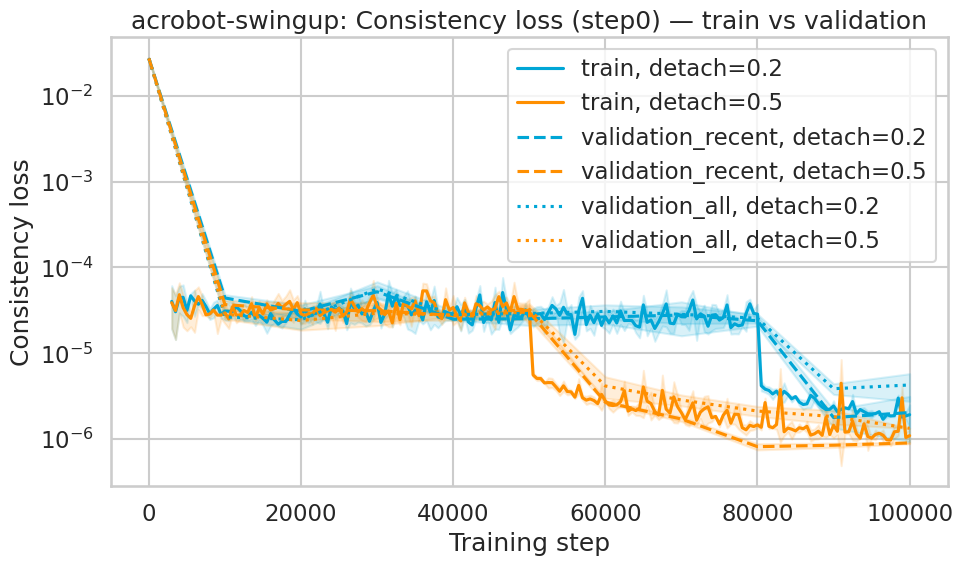

Task quadruped-walk: found detach_encoder_ratio values [0.2, 0.5]


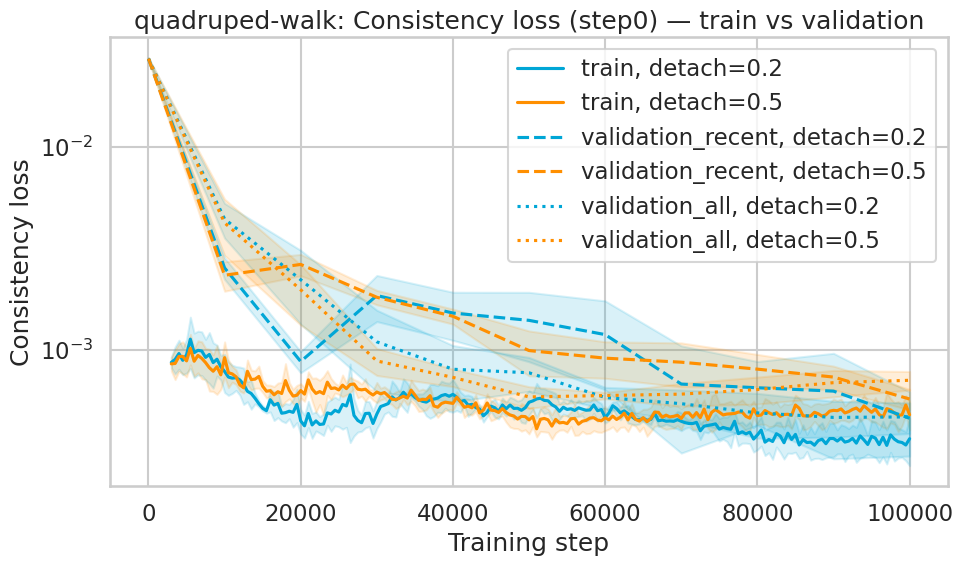

In [10]:
for task_name in ["acrobot-swingup", "quadruped-walk"]:
    if task_name not in agg_consistency_df["task"].unique():
        print(f"Task {task_name} not present in aggregated dataframe; skipping.")
        continue
    plot_task_consistency(agg_consistency_df, task_name)

In [11]:
# Diagnostics: inspect which consistency / validation metrics are actually present
metric_columns = [c for c in raw_consistency_df.columns if "consistency" in c or "validation" in c or "val_" in c]
metric_columns

['validation_recent/consistency_loss/step0',
 'validation_recent/consistency_loss/step1',
 'validation_all/consistency_loss/step0',
 'validation_all/consistency_loss/step1',
 'train/consistency_loss/step0',
 'train/consistency_loss/step1']